In [1]:
import torch
from dataset import load_dataset
from basic_unet import UNet
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.spatial.distance import directed_hausdorff, dice
from plot_utils import plot_image_row

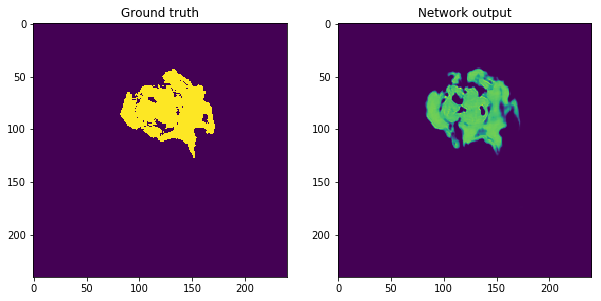

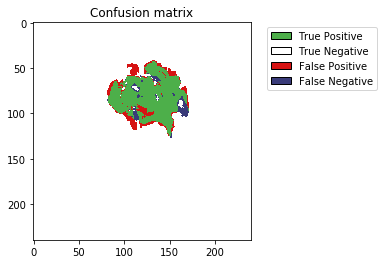

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader, test_loader = load_dataset(1)

model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

COLOR_LABEL = '#393B79'  # 1 = blue, only on label segment
COLOR_NETWORK = '#d61313'  # 2 = red, only on network output
COLOR_BOTH = '#4DAF4A'  # 3 = green, on both segments

cmap = ListedColormap(colors=[
    (1.0, 1.0, 1.0),
    COLOR_LABEL,
    COLOR_NETWORK,
    COLOR_BOTH,
])

# ground truth vs network output
sample = next(iter(test_loader))
segment = sample['segment']
segment = segment.squeeze()

image = sample['input'].to(device)
output = model(image)
output = output.detach().cpu().squeeze().numpy()

plot_image_row([segment, output], labels=['Ground truth', 'Network output'])

# confusion matrix
output_threshold = (output > output.mean()).astype(int)
segment_threshold = (segment.numpy() > 0).astype(int)
plot = plt.subplot()
plot.imshow(output_threshold * 2 + segment_threshold, cmap=cmap)
plot.set_title('Confusion matrix')
true_positive = mpatches.Patch(facecolor=COLOR_BOTH, edgecolor='black', label='True Positive')
true_negative = mpatches.Patch(facecolor='white', edgecolor='black', label='True Negative')
false_negative = mpatches.Patch(facecolor=COLOR_LABEL, edgecolor='black', label='False Negative')
false_positive = mpatches.Patch(facecolor=COLOR_NETWORK, edgecolor='black', label='False Positive')
plot.legend(
    handles=[true_positive, true_negative, false_positive, false_negative],
    loc=2,
    bbox_to_anchor=(1.05, 1)
)
plt.show()

In [3]:
print('Hausdorff distances:')
print(directed_hausdorff(output_threshold, segment_threshold)[0])
print(directed_hausdorff(segment_threshold, output_threshold)[0])

Hausdorff distances:
4.358898943540674
5.5677643628300215


In [4]:
print('Dice coefficient/F1 score')
print(dice(output_threshold.reshape(240 * 240), segment_threshold.reshape(240 * 240)))

Dice coefficient/F1 score
0.1505635051285298
